# Chaya Chandana

#Densenet

# Mount Google Drive

In [1]:
# Mount Google Drive (optional)
from google.colab import drive
import sys
drive.mount('/content/drive/')

Mounted at /content/drive/


# Import Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import densenet121
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Dataset Path and Device Configuration

In [3]:
# Dataset path (update if needed)
root_path = '/content/drive/My Drive/Project/dataset/'  # Ensure the dataset is uploaded here

# Check dataset existence
if not os.path.exists(root_path) or len(os.listdir(root_path)) == 0:
    raise ValueError(f"The dataset folder '{root_path}' is empty or does not exist. Please check your dataset.")

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Warning

In [5]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

## Matplotlib

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

## TensorFlow

In [9]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Random seed

In [10]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

## Data Augmentation and DataLoader

In [76]:
# Data Augmentation and Normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(20, shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # DenseNet normalization
])

# Load Dataset
dataset = torchvision.datasets.ImageFolder(root=root_path, transform=transform)

# Train-Validation Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Loading the data

In [77]:
dataset = torchvision.datasets.ImageFolder(root=root_path, transform=transform)

## Model Definition and Setup

## Training

## Train the Model

## Getting the Name of the Target

In [78]:
import os
# Assuming the dataset is stored in a directory with subfolders as class names
data_dir = '/content/drive/My Drive/Project/dataset/'  # Update this path as needed
class_names = os.listdir(data_dir)
print(f"Class Names: {class_names}")

Class Names: ['sandstorm', 'dew', 'hail', 'fogsmog', 'frost', 'snow', 'rainbow', 'rime', 'glaze', 'rain', 'lightning']


## Getting Information About the Dataset

In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Basic information about dataset
image_generator = ImageDataGenerator(validation_split=0.2)
data_iterator = image_generator.flow_from_directory(data_dir, target_size=(256, 256), batch_size=32)

print(f"Number of classes: {len(data_iterator.class_indices)}")
print(f"Class indices: {data_iterator.class_indices}")

Found 6862 images belonging to 11 classes.
Number of classes: 11
Class indices: {'dew': 0, 'fogsmog': 1, 'frost': 2, 'glaze': 3, 'hail': 4, 'lightning': 5, 'rain': 6, 'rainbow': 7, 'rime': 8, 'sandstorm': 9, 'snow': 10}


## Loading Training, Validation, and Test Data

In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
image_size = (256, 256)

train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = train_gen.flow_from_directory(data_dir, target_size=image_size, batch_size=batch_size, subset='training', shuffle=True)
val_data = train_gen.flow_from_directory(data_dir, target_size=image_size, batch_size=batch_size, subset='validation', shuffle=False)

# Assuming a separate test dataset
test_dir = '/content/drive/My Drive/Project/dataset/'  # Update this path if necessary
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(test_dir, target_size=image_size, batch_size=batch_size, shuffle=False)

Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.
Found 6862 images belonging to 11 classes.


## Preprocessing the Data Using Pretrained Model

In [81]:
from tensorflow.keras.applications import densenet

preprocess_input = densenet.preprocess_input

# Apply preprocessing to all data generators
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
train_data = train_gen.flow_from_directory(data_dir, target_size=image_size, batch_size=batch_size, subset='training', shuffle=True)
val_data = train_gen.flow_from_directory(data_dir, target_size=image_size, batch_size=batch_size, subset='validation', shuffle=False)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_gen.flow_from_directory(test_dir, target_size=image_size, batch_size=batch_size, shuffle=False)

Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.
Found 6862 images belonging to 11 classes.


## Shuffling, Batching, and Prefetching the Data

In [82]:
import tensorflow as tf

# Convert DirectoryIterator to tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data,
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(class_names)), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_data,
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(class_names)), dtype=tf.float32)
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_data,
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(class_names)), dtype=tf.float32)
    )
)

# Shuffle, batch, and prefetch the data
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

## Training: Creating a Directory for the Model

In [83]:
import os

model_dir = '/content/models'
os.makedirs(model_dir, exist_ok=True)
print(f"Model directory created: {model_dir}")

Model directory created: /content/models


In [84]:
num_classes = len(class_names)  # Number of classes in the dataset
print(f"Number of classes in the dataset: {num_classes}")

Number of classes in the dataset: 11


In [85]:
output = Dense(num_classes, activation='softmax')(x)  # Ensure num_classes matches the dataset
model = Model(inputs=base_model.input, outputs=output)

## Building the Architecture of the Model

In [86]:
# Build the architecture with the correct number of classes
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

base_model = DenseNet121(include_top=False, input_shape=(256, 256, 3), weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)

# Update the output layer to match the number of classes in the dataset
num_classes = len(class_names)  # Ensure this is correct
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
print(model.summary())

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_6          │ (None, 262, 262, 3)    │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d_6[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_7          │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ zero_padding2d_7[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 64, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 64, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 40,598,091 (154.87 MB)

 Trainable params: 40,514,443 (154.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

None


## Freezing the Pretrained Layers

In [87]:
for layer in base_model.layers:
    layer.trainable = False

## Setting Callbacks

In [90]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save the best model using .keras format
checkpoint = ModelCheckpoint(filepath=f'{model_dir}/best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Compiling the Model

In [91]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training the Model

In [92]:
history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[checkpoint, early_stopping])

Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 3973s 22s/step - accuracy: 0.5891 - loss: 6.2472 - val_accuracy: 0.8232 - val_loss: 0.4773
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 53s 296ms/step - accuracy: 0.8960 - loss: 0.2782 - val_accuracy: 0.8386 - val_loss: 0.5380
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 81s 295ms/step - accuracy: 0.9476 - loss: 0.1481 - val_accuracy: 0.8232 - val_loss: 0.6595
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 52s 292ms/step - accuracy: 0.9654 - loss: 0.1065 - val_accuracy: 0.8517 - val_loss: 0.5473
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - accuracy: 0.9755 - loss: 0.0729 - val_accuracy: 0.8663 - val_loss: 0.5911
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 83s 298ms/step - accuracy: 0.9823 - loss: 0.0518 - val_accuracy: 0.8612 - val_loss: 0.5766


## Plotting the Learning Curve

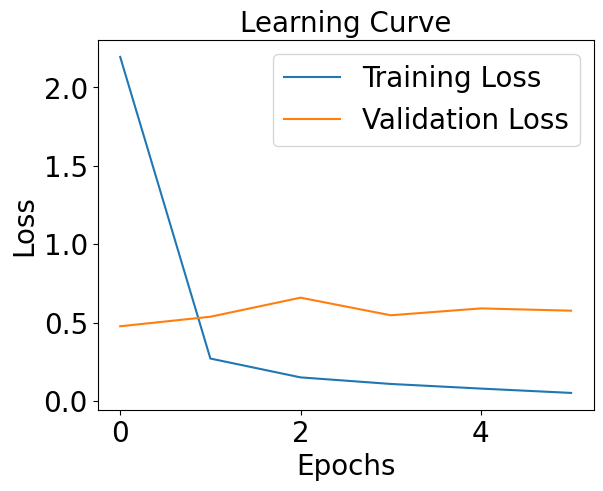

In [93]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()

## Creating a Directory for the Figure

In [94]:
figure_dir = '/content/figures'
os.makedirs(figure_dir, exist_ok=True)
plt.savefig(f'{figure_dir}/learning_curve.png')

<Figure size 640x480 with 0 Axes>

## Unfreezing the Pretrained Layers

In [95]:
for layer in base_model.layers:
    layer.trainable = True

## Compiling the Model (After Unfreezing)

In [96]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training the Model (After Unfreezing)

In [97]:
history_unfreeze = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[checkpoint, early_stopping])

Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.6666 - loss: 1.1650 - val_accuracy: 0.6370 - val_loss: 1.5936
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 75s 424ms/step - accuracy: 0.7949 - loss: 0.6512 - val_accuracy: 0.7151 - val_loss: 1.1548
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 77s 432ms/step - accuracy: 0.8570 - loss: 0.4755 - val_accuracy: 0.7641 - val_loss: 1.0111
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 76s 430ms/step - accuracy: 0.8593 - loss: 0.4499 - val_accuracy: 0.7721 - val_loss: 0.8346
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 76s 431ms/step - accuracy: 0.8483 - loss: 0.5057 - val_accuracy: 0.6903 - val_loss: 1.1881


## Plotting the Learning Curve (After Unfreezing)

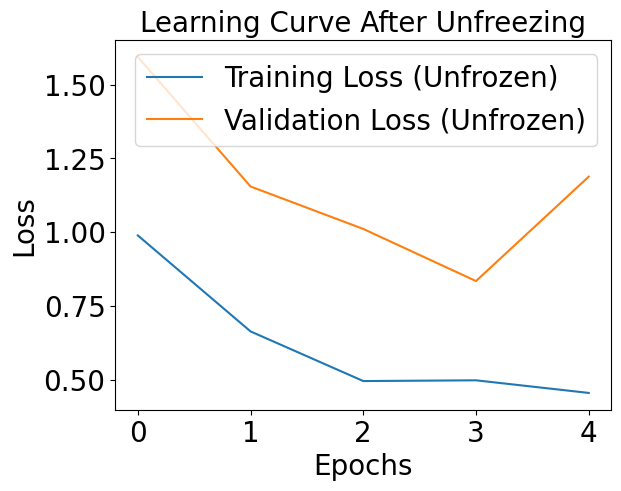

<Figure size 640x480 with 0 Axes>

In [98]:
plt.plot(history_unfreeze.history['loss'], label='Training Loss (Unfrozen)')
plt.plot(history_unfreeze.history['val_loss'], label='Validation Loss (Unfrozen)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve After Unfreezing')
plt.show()

plt.savefig(f'{figure_dir}/learning_curve_unfreeze.png')

## Testing the Model

In [99]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

215/215 ━━━━━━━━━━━━━━━━━━━━ 65s 301ms/step - accuracy: 0.4834 - loss: 4.1774
Test Loss: 4.9560, Test Accuracy: 0.3999
